# Graph construction development using the TrackML dataset

In [1]:
import sys
sys.path.append('/global/homes/s/sfarrell/.local/cori/3.6-anaconda-4.4/lib/python3.6/site-packages')

In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from trackml import dataset

from graph import make_sparse_graph, graph_from_sparse
#from graph import construct_graph

In [3]:
%matplotlib notebook

## Load the data

In [4]:
# NERSC path
data_dir = '/global/cscratch1/sd/sfarrell/trackml/train_100_events'

# iBanks path
#data_dir = '/bigdata/shared/TrackML/train_100_events'

### temp

In [34]:
all_files = os.listdir(data_dir)

suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(data_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

#dataset.load_event

In [51]:
dataset.load_event?

### end temp

In [5]:
# Start with just one event
n_events = 1

data_itr = dataset.load_dataset(data_dir, nevents=n_events)
evtid, hits, cells, particles, truth = next(data_itr)

In [6]:
hits.head(1)

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.1637,-1502.5,7,2,1


In [7]:
cells.head(1)

,hit_id,ch0,ch1,value
0,1,209,617,0.013832


In [8]:
particles.head(1)

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8


In [9]:
truth.head(1)

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.16412,-1502.5,250710.0,-149908.0,-956385.0,0.0


## Select the barrel hits

In [10]:
def select_hits(hits, truth, particles, pt_min=0):
    # Barrel volume and layer ids
    vlids = [(8,2), (8,4), (8,6), (8,8),
             (13,2), (13,4), (13,6), (13,8),
             (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    # Calculate particle transverse momentum
    pt = np.sqrt(particles.px**2 + particles.py**2)
    # True particle selection.
    # Applies pt cut, removes all noise hits.
    particles = particles[pt > pt_min]
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id']], on='particle_id'))
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id']], on='hit_id'))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [11]:
%%time

# True pt cut
pt_min = 1 # GeV

hits = select_hits(hits, truth, particles, pt_min=pt_min).assign(evtid=evtid)

CPU times: user 904 ms, sys: 41.5 ms, total: 946 ms
Wall time: 950 ms


In [12]:
hits.shape

(6437, 7)

## Determine geometric constraints

In [13]:
# Define adjacent layers
n_det_layers = 10
l = np.arange(n_det_layers)
layer_pairs = np.stack([l[:-1], l[1:]], axis=1)

In [14]:
%%time

layer_groups = hits.groupby('layer')
segments = []

for (layer1, layer2) in layer_pairs:
    hits1 = layer_groups.get_group(layer1)
    hits2 = layer_groups.get_group(layer2)
    # Join all pairs together
    hit_pairs = hits1.merge(hits2, how='inner', on='evtid', suffixes=('_1', '_2'))
    

    # Calculate coordinate differences
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1

    # Identify the true pairs
    y = (hit_pairs.particle_id_1 == hit_pairs.particle_id_2) & (hit_pairs.particle_id_1 != 0)

    # phi-r slope
    phi_slopes = dphi / dr
    # R-Z intercept
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr

    # Put the results in a new dataframe
    segments.append(hit_pairs[['evtid', 'layer_1', 'layer_2']]
                    .assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slopes, z0=z0))

segments = pd.concat(segments, ignore_index=True)

CPU times: user 989 ms, sys: 386 ms, total: 1.37 s
Wall time: 1.36 s


In [15]:
segments.head()

,evtid,layer_1,layer_2,dphi,dz,dr,y,phi_slope,z0
0,1000,0,1,-0.011841,77.279800,40.713783,True,-0.000291,-0.093605
1,1000,0,1,2.852896,-187.588196,41.218735,False,0.069214,202.708221
2,1000,0,1,2.468985,-196.671204,41.084846,False,0.060095,210.126709
3,1000,0,1,0.214906,-82.072502,40.459373,False,0.005312,123.384354
4,1000,0,1,0.159549,-325.020203,40.472969,False,0.003942,312.125580


<IPython.core.display.Javascript object>


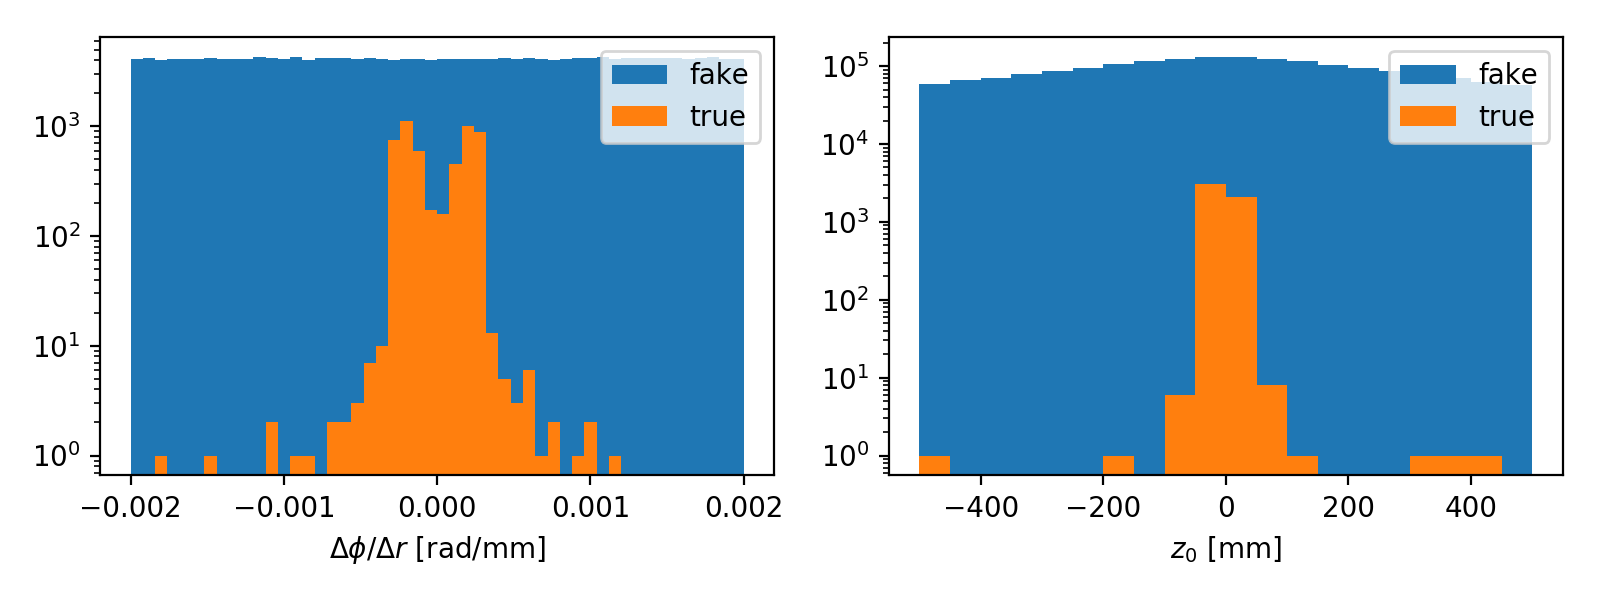

CPU times: user 1.83 s, sys: 571 ms, total: 2.4 s
Wall time: 2.41 s


In [16]:
%%time

plt.figure(figsize=(8,3))

true_segs = segments[segments.y]
fake_segs = segments[segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.002, 0.002))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=20, range=(-500, 500))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

## Construct graphs

In [17]:
def split_phi_sectors(hits, n_phi_sectors=8):
    phi_sector_width = 2 * np.pi / n_phi_sectors
    phi_sector_edges = np.linspace(-np.pi, np.pi, n_phi_sectors + 1)
    hits_sectors = []
    # Loop over phi sectors
    for i in range(n_phi_sectors):
        phi_sector_min, phi_sector_max = phi_sector_edges[i:i+2]    
        # Select hits from this sector
        sector_hits = hits[(hits.phi > phi_sector_min) & (hits.phi < phi_sector_max)]
        # Center the phi sector on 0
        centered_phi = sector_hits.phi - phi_sector_min - phi_sector_width / 2
        sector_hits = sector_hits.assign(phi=centered_phi, phi_sector=i)
        hits_sectors.append(sector_hits)
    # Return results
    return hits_sectors

In [18]:
def select_segments(hits1, hits2, phi_slope_max, z0_max):
    """
    Construct a list of selected segments from the pairings
    between hits1 and hits2, filtered with the specified
    phi slope and z0 criteria.

    Returns: pd DataFrame of (index_1, index_2), corresponding to the
    DataFrame hit label-indices in hits1 and hits2, respectively.
    """
    # Start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    # Filter segments according to criteria
    good_seg_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    return hit_pairs[['index_1', 'index_2']][good_seg_mask]

In [19]:
def construct_segments(hits, layer_pairs,
                       phi_slope_max, z0_max):
    """
    Construct a list of selected segments from hits DataFrame using
    the specified layer pairs and selection criteria.

    Returns: DataFrame of (index_1, index_2) corresponding to the
    hit indices of the selected segments.
    """
    # Loop over layer pairs and construct segments
    layer_groups = hits.groupby('layer')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            logging.info('skipping empty layer: %s' % e)
            continue
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max, z0_max))
    # Combine segments from all layer pairs
    return pd.concat(segments)

In [20]:
def construct_graph(hits, layer_pairs,
                    phi_slope_max, z0_max,
                    feature_names, feature_scale):
    """Construct one graph (e.g. from one event)"""
    # Construct segments
    segments = construct_segments(hits, layer_pairs,
                                  phi_slope_max=phi_slope_max,
                                  z0_max=z0_max)
    n_hits = hits.shape[0]
    n_edges = segments.shape[0]
    #evtid = hits.evtid.unique()
    # Prepare the tensors
    X = (hits[feature_names].values / feature_scale).astype(np.float32)
    Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
    Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
    y = np.zeros(n_edges, dtype=np.float32)
    # We have the segments' hits given by dataframe label,
    # so we need to translate into positional indices.
    # Use a series to map hit label-index onto positional-index.
    hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
    seg_start = hit_idx.loc[segments.index_1].values
    seg_end = hit_idx.loc[segments.index_2].values
    # Now we can fill the association matrices.
    # Note that Ri maps hits onto their incoming edges,
    # which are actually segment endings.
    Ri[seg_end, np.arange(n_edges)] = 1
    Ro[seg_start, np.arange(n_edges)] = 1
    # Fill the segment labels
    pid1 = hits.particle_id.loc[segments.index_1].values
    pid2 = hits.particle_id.loc[segments.index_2].values
    y[:] = (pid1 == pid2)
    # Return a tuple of the results
    return make_sparse_graph(X, Ri, Ro, y)
    #return Graph(X, Ri, Ro, y)

In [21]:
n_phi_sectors = 8
hits_sectors = split_phi_sectors(hits, n_phi_sectors=n_phi_sectors)

In [22]:
# Just look at one for now
sector_hits = hits_sectors[0]

In [23]:
# Segment selection criteria
phi_slope_max = 0.001
z0_max = 200

# Graph features and scale
feature_names = ['r', 'phi', 'z']
feature_scale = np.array([1000., np.pi / n_phi_sectors, 1000.])

# Define adjacent layers
n_det_layers = 10
l = np.arange(n_det_layers)
layer_pairs = np.stack([l[:-1], l[1:]], axis=1)

In [24]:
graph = construct_graph(sector_hits, layer_pairs=layer_pairs,
                        phi_slope_max=phi_slope_max, z0_max=z0_max,
                        feature_names=feature_names, feature_scale=feature_scale)

In [25]:
graph.X.shape, graph.y.shape, graph.y.mean()

((932, 3), (3446,), 0.21561231)

## Visualize graph

In [26]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

In [27]:
g = graph_from_sparse(graph)

<IPython.core.display.Javascript object>


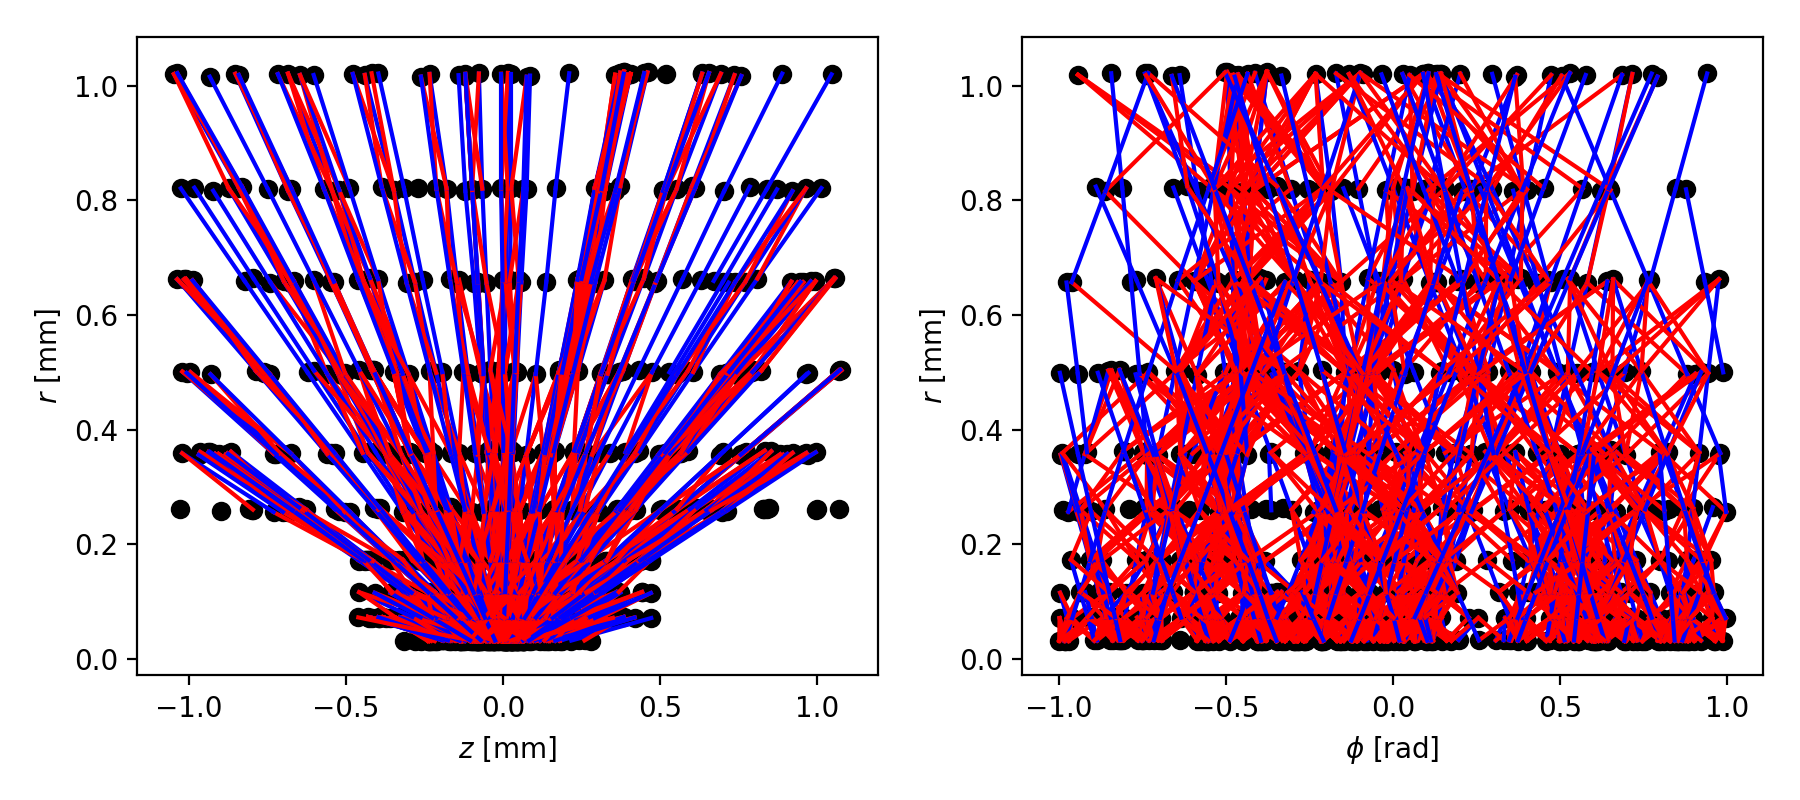

In [28]:
draw_sample(g.X, g.Ri, g.Ro, g.y)